In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


구글 드라이브에서 일별 환자 유입 수를 다운로드합니다.


In [2]:
!gdown --id 1VFP4Xe_UrznhCxU84I7pDjNnz4sqcASD

Downloading...
From: https://drive.google.com/uc?id=1VFP4Xe_UrznhCxU84I7pDjNnz4sqcASD
To: /content/daily_confirmed.csv
100% 1.94k/1.94k [00:00<00:00, 1.58MB/s]


## 데이터 확인

In [3]:
df = pd.read_csv('daily_confirmed.csv')
df.head()

,#NAME?,2020/4/1,2020/4/2,2020/4/3,2020/4/4,2020/4/5,2020/4/6,2020/4/7,2020/4/8,2020/4/9,2020/4/10,2020/4/11,2020/4/12,2020/4/13,2020/4/14,2020/4/16,2020/4/17,2020/4/18,2020/4/19,2020/4/20,2020/4/21,2020/4/22,2020/4/23,2020/4/24,2020/4/25,2020/4/26,2020/4/27,2020/4/28,2020/4/29,2020/4/30,2020/5/1,2020/5/2,2020/5/3,2020/5/4,2020/5/5,2020/5/6,2020/5/7,2020/5/8,2020/5/9,2020/5/10,2020/5/11,2020/5/12,2020/5/13,2020/5/14,2020/5/15,2020/5/16,2020/5/17,2020/5/18,2020/5/19,2020/5/20,2020/5/21,2020/5/22,2020/5/23,2020/5/25,2020/5/26,2020/5/27,2020/5/28,2020/5/29,2020/5/30,2020/5/31,2020/6/1,2020/6/2,2020/6/3,2020/6/4,2020/6/5,2020/6/6,2020/6/8
0,China,17,17,17,17,17,17,17,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17,17,17,17,17,17,18,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
1,Asia,64,67,71,82,85,85,87,92,95,95,96,98,100,100,104,107,108,108,108,109,111,112,112,112,115,117,121,122,123,127,129,133,139,140,142,143,151,152,154,156,157,160,162,165,171,172,178,178,184,185,193,197,202,204,205,213,214,220,225,225,226,230,233,234,237,241
2,Eroupe,298,316,338,355,372,378,389,401,408,410,414,418,421,423,431,434,437,439,439,440,442,442,442,443,446,448,454,456,456,457,460,462,461,462,462,462,462,461,462,463,464,464,464,465,466,467,468,468,468,468,468,468,469,469,469,469,469,472,473,475,475,475,475,476,476,476
3,America,178,198,218,240,264,286,306,320,339,345,357,377,389,398,412,422,428,431,439,442,444,446,448,451,455,458,460,461,463,466,469,473,476,477,477,479,482,483,485,487,489,490,491,492,495,500,503,507,509,510,511,511,516,517,519,522,524,527,533,536,537,538,539,542,547,552
4,Africa,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,6,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8


각 국가별로 나누어서 따로 산출할 수도 있지만, 일단 모든 국가별 유입자수를 합하여 계산합니다.

각 날짜별 누적 유입자 수를 모두 합칩니다
(Dataframe -> series)

matplot가 날짜를 인식할 수 있도록 pandas의 to_datetime을 사용합니다.

In [0]:
daily_cases = df.sum(axis=0)
daily_cases = daily_cases.drop(daily_cases.index[0])
daily_cases.index = pd.to_datetime(daily_cases.index)

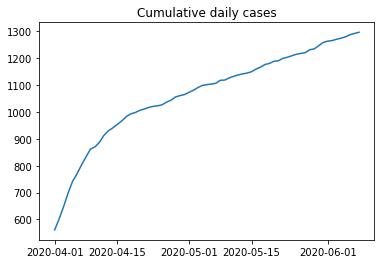

In [5]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

누적 확진자 수에서 일별 확진자 수 증가량을 확인하기 위해 이전 항의 값을 빼 줍니다.

In [6]:
daily_cases = daily_cases.diff().dropna().astype(np.int64)
daily_cases.head()

2020-04-02    41
2020-04-03    46
2020-04-04    50
2020-04-05    44
2020-04-06    28
dtype: int64

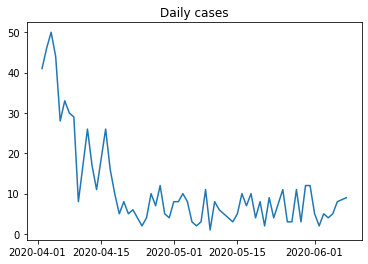

In [7]:
plt.plot(daily_cases)
plt.title("Daily cases");

일별 유입자 수에 대한 데이터를 확보했습니다.

데이터의 양은 다음과 같습니다.

In [8]:
daily_cases.shape

(65,)

## 전처리 작업

데이터의 성능 측정을 위해 10일 정도를 테스트 데이터로 분류합니다:

In [10]:
test_data_size = 10

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

print(test_data)
train_data.shape

2020-05-29     3
2020-05-30    12
2020-05-31    12
2020-06-01     5
2020-06-02     2
2020-06-03     5
2020-06-04     4
2020-06-05     5
2020-06-06     8
2020-06-08     9
dtype: int64


(55,)

성능의 향상을 위해 sciket-learn이 제공하는 Scaler를 사용합니다.
(MinMaxScaler 외에도 다른 Scaler들이 있으나, 시험해보지 않았습니다.)

In [11]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

print(test_data)


[[0.04081633]
 [0.2244898 ]
 [0.2244898 ]
 [0.08163265]
 [0.02040816]
 [0.08163265]
 [0.06122449]
 [0.08163265]
 [0.14285714]
 [0.16326531]]


거대한 덩어리를 가지고 한번에 예측을 다 끝낼 수 없으므로, 한 점을 기준으로 5일 이전까지의 데이터를 가지고 그 다음 날의 값을 예측하도록 했습니다.

In [0]:

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [13]:
seq_length = 7
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

print (y_test)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

[[0.08163265]
 [0.14285714]]


작업이 끝나면 X의 값은 3차원 배열의 형태를 가지게 됩니다.

In [14]:
X_train.shape

torch.Size([47, 7, 1])

## 모델 만들기


In [0]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.fc_layer=nn.Sequential(
        ##n_hidden이 입력 인자의 개수이므로, concat이 진행되었다면 첫 번째 인자는 n_hidden + len(새로운 데이터)값이 되어야 함.
        nn.Linear(n_hidden, 512),

        nn.ELU(),
        nn.Dropout2d(0.2),
        
        nn.Linear(512,10),
        nn.Linear(10,1)
    )

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    ## 이곳에 추가 데이터 입력
    ## last_time_step(아마 tensor 자료형)과 새로운 데이터에 concat를 수행
    y_pred = self.fc_layer(last_time_step)
    return y_pred

기본적인 구조는 CNN과 비슷합니다.

forward에서 코드가 진행되며 convolution을 진행하는 대신, LSTM(Long Short-Term Memory models)를 사용합니다.

매번 돌릴때마다 hidden_state 또한 초기화시켜주어야 하기 때문에 reset_hidden_state를 사용합니다.



## 학습 함수


In [0]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(),lr=1e-3)
  num_epochs = 100

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [21]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=1024, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 1.4214009046554565 test loss: 0.015214908868074417
Epoch 10 train loss: 0.769065797328949 test loss: 0.0027363828849047422
Epoch 20 train loss: 0.7652221322059631 test loss: 0.00490500358864665
Epoch 30 train loss: 0.7643346786499023 test loss: 0.0055848704650998116
Epoch 40 train loss: 0.7455745339393616 test loss: 0.0045377095229923725
Epoch 50 train loss: 0.7180489897727966 test loss: 0.0035720637533813715
Epoch 60 train loss: 0.7648704051971436 test loss: 0.009980378672480583
Epoch 70 train loss: 0.7493295073509216 test loss: 0.003073429688811302
Epoch 80 train loss: 0.8404231667518616 test loss: 0.018905697390437126
Epoch 90 train loss: 1.108719825744629 test loss: 0.039082251489162445


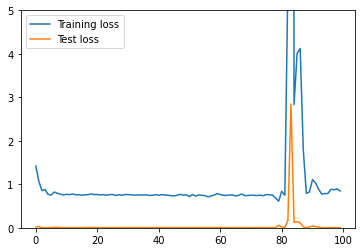

In [22]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

## 예측

원래 이 모델은 주어진 데이터의 다음날까지밖에 예측할 수 없지만,
예측 값을 사용하여 그 다음날을 예측하는 방식으로 더 많은 날을 에측합니다. 

In [0]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

직관성을 위해 이전에 scaling 했던 것을 다시 돌려놓습니다.

In [0]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

그래프를 찍습니다,

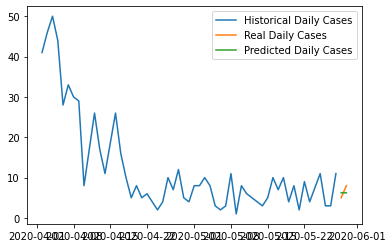

In [25]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

## + 모든 데이터 사용하기

모든 데이터를 학습에 사용해보았습니다. 이렇게 하면 검증 단계가 빠지는 대신 미래의 결과를 예측할 수 있습니다. (최종 단계)

In [26]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(65, 1)

In [27]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=1024, 
  seq_len=seq_length, 
  n_layers=4
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 3.4509341716766357
Epoch 10 train loss: 2.654116630554199
Epoch 20 train loss: 0.8934652805328369
Epoch 30 train loss: 0.887997567653656
Epoch 40 train loss: 0.7986295819282532
Epoch 50 train loss: 0.742999255657196
Epoch 60 train loss: 0.7766262292861938
Epoch 70 train loss: 0.7612345218658447
Epoch 80 train loss: 0.7864864468574524
Epoch 90 train loss: 0.7660518288612366


## 예측하기


In [0]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [30]:
daily_cases.index[-1]

Timestamp('2020-06-08 00:00:00')

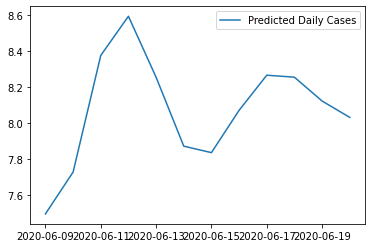

In [31]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [32]:
all_data

array([[0.81632653],
       [0.91836735],
       [1.        ],
       [0.87755102],
       [0.55102041],
       [0.65306122],
       [0.59183673],
       [0.57142857],
       [0.14285714],
       [0.32653061],
       [0.51020408],
       [0.32653061],
       [0.20408163],
       [0.51020408],
       [0.30612245],
       [0.18367347],
       [0.08163265],
       [0.14285714],
       [0.08163265],
       [0.10204082],
       [0.06122449],
       [0.02040816],
       [0.06122449],
       [0.18367347],
       [0.12244898],
       [0.2244898 ],
       [0.08163265],
       [0.06122449],
       [0.14285714],
       [0.14285714],
       [0.18367347],
       [0.14285714],
       [0.04081633],
       [0.02040816],
       [0.04081633],
       [0.20408163],
       [0.        ],
       [0.14285714],
       [0.10204082],
       [0.08163265],
       [0.06122449],
       [0.04081633],
       [0.08163265],
       [0.18367347],
       [0.12244898],
       [0.18367347],
       [0.06122449],
       [0.142

그래프 찍기

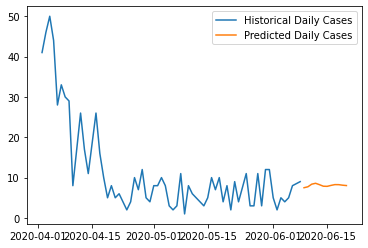

In [33]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

## 결론

## References

- [Sequence Models PyTorch Tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
- [LSTM for time series prediction](https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca)
- [Time Series Prediction using LSTM with PyTorch in Python](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)
- [Stateful LSTM in Keras](https://philipperemy.github.io/keras-stateful-lstm/)
- [LSTMs for Time Series in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/)
- [covid-19-analysis](https://github.com/AaronWard/covid-19-analysis)
- [Statistical Consequences of Fat Tails: Real World Preasymptotics, Epistemology, and Applications](https://www.researchers.one/article/2020-01-21)
- [covid-19 Forecasting with an RNN](https://www.kaggle.com/frlemarchand/covid-19-forecasting-with-an-rnn/input?select=test.csv)
- [Time Series Forecasting with LSTMs for Daily Coronavirus Cases using PyTorch in Python](https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/)